### __Unterschied zwischen einem Modell für alles und getrennten Modellen__

In [3]:
import model_utils
import pandas as pd
import importlib
importlib.reload(model_utils)

merged_hornsea = pd.read_parquet("Data/preprocessed_hornsea_with_energy.parquet")
merged_pes = pd.read_parquet("Data/preprocessed_pes_with_energy.parquet")

#combine solar and wind weather data
columns_to_add = list()

for col in merged_hornsea.columns:
    if col not in merged_pes.columns:
        columns_to_add.append(col)

merged_all = merged_pes.merge(merged_hornsea[columns_to_add], left_index = True, right_index = True)
merged_all["energy"] = merged_all["Solar_MWh_credit"] + merged_all["Wind_MWh_credit"]       #combine label
merged_all.drop(["Solar_MWh_credit", "Wind_MWh_credit"], axis = 1, inplace = True)

#train or load one model for solar and wind energy
from Preprocessing import *
feature_engineerer_all = FeatureEngineerer(labels_to_remove=  ["energy"], columns_to_ohe = ['unavailabilityType', 'affectedUnit'], label = ["energy"])
feature_engineerer_all.perform_feature_engineering(merged_all, deployment = False, labels_to_remove=  ["energy"])

import numpy as np
quantiles = np.arange(0.1, 1.0, 0.1).round(2)

# Specify model save directory
model_save_dir_qr = "lgbm_model_all"

lgbm_model = model_utils.LGBMRegressorModel(feature_engineerer_all, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
lgbm_model.train_and_predict()  # This will skip training for already loaded models
# print(f"Quantile Regressor Pinball Score: {lgbm_model.pinball_score()}")

Loaded pretrained Quantile Regressor model for quantile 0.1 from lgbm_model_all\lgbm_model_quantile_0.1.pkl
Loaded pretrained Quantile Regressor model for quantile 0.2 from lgbm_model_all\lgbm_model_quantile_0.2.pkl
Loaded pretrained Quantile Regressor model for quantile 0.3 from lgbm_model_all\lgbm_model_quantile_0.3.pkl
Loaded pretrained Quantile Regressor model for quantile 0.4 from lgbm_model_all\lgbm_model_quantile_0.4.pkl
Loaded pretrained Quantile Regressor model for quantile 0.5 from lgbm_model_all\lgbm_model_quantile_0.5.pkl
Loaded pretrained Quantile Regressor model for quantile 0.6 from lgbm_model_all\lgbm_model_quantile_0.6.pkl
Loaded pretrained Quantile Regressor model for quantile 0.7 from lgbm_model_all\lgbm_model_quantile_0.7.pkl
Loaded pretrained Quantile Regressor model for quantile 0.8 from lgbm_model_all\lgbm_model_quantile_0.8.pkl
Loaded pretrained Quantile Regressor model for quantile 0.9 from lgbm_model_all\lgbm_model_quantile_0.9.pkl
Using the loaded pretrained 

In [4]:
importlib.reload(model_utils)
import Preprocessing

feature_engineerer_wind = Preprocessing.FeatureEngineerer(label = 'Wind_MWh_credit', columns_to_ohe = ['unavailabilityType', 'affectedUnit'])
feature_engineerer_wind.perform_feature_engineering(merged_hornsea, deployment = False)

feature_engineerer_solar = Preprocessing.FeatureEngineerer(label = "Solar_MWh_credit")
feature_engineerer_solar.perform_feature_engineering(merged_pes, deployment = False)

quantiles = np.arange(0.1, 1.0, 0.1)
quantiles = np.round(quantiles, 1)

# Specify model save directory
model_save_dir_qr = "lgbm_model_wind"

# train or load model for wind energy
lgbm_model_wind = model_utils.LGBMRegressorModel(feature_engineerer_wind, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
lgbm_model_wind.train_and_predict()  # This will skip training for already loaded models

# Specify model save directory
model_save_dir_qr = "lgbm_model_solar"

#train or load model for solar energy
lgbm_model_solar = model_utils.LGBMRegressorModel(feature_engineerer_solar, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
lgbm_model_solar.train_and_predict()  # This will skip training for already loaded models

# combine solar and wind energy from two models
solar_energy = lgbm_model_solar.q_predictions
wind_energy = lgbm_model_wind.q_predictions

combined_energy = {key: solar_energy[key] + wind_energy[key] for key in solar_energy}

Loaded pretrained Quantile Regressor model for quantile 0.1 from lgbm_model_wind\lgbm_model_quantile_0.1.pkl
Loaded pretrained Quantile Regressor model for quantile 0.2 from lgbm_model_wind\lgbm_model_quantile_0.2.pkl
Loaded pretrained Quantile Regressor model for quantile 0.3 from lgbm_model_wind\lgbm_model_quantile_0.3.pkl
Loaded pretrained Quantile Regressor model for quantile 0.4 from lgbm_model_wind\lgbm_model_quantile_0.4.pkl
Loaded pretrained Quantile Regressor model for quantile 0.5 from lgbm_model_wind\lgbm_model_quantile_0.5.pkl
Loaded pretrained Quantile Regressor model for quantile 0.6 from lgbm_model_wind\lgbm_model_quantile_0.6.pkl
Loaded pretrained Quantile Regressor model for quantile 0.7 from lgbm_model_wind\lgbm_model_quantile_0.7.pkl
Loaded pretrained Quantile Regressor model for quantile 0.8 from lgbm_model_wind\lgbm_model_quantile_0.8.pkl
Loaded pretrained Quantile Regressor model for quantile 0.9 from lgbm_model_wind\lgbm_model_quantile_0.9.pkl
Using the loaded pr

__vergleich der beiden Modelle__  
es handelt sich jeweils um lightgbm modelle ohne Hyperparametertuning

In [5]:
performance_scores = {'all_in_one_Modell' : [lgbm_model.pinball_score()],
                      'Solar+Windenergie' : [model_utils.pinball_score(combined_energy, quantiles)]
                      }
performance_df = pd.DataFrame(performance_scores, index=["total_energy"])
performance_df

,all_in_one_Modell,Solar+Windenergie
total_energy,26.247761,26.091434


### __Modelle die Verglichen werden__

- Baseline Modell
- LGBM (mit Hyperparametertuning)
- conformalized quantile prediction
- LSTM
- CNN_LSTM
- Ensemble Modell

__Baseline__

In [6]:
merged_pes_simple = merged_pes[['solar_down_rad', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_solar_baseline = Preprocessing.FeatureEngineerer(label = 'Solar_MWh_credit')
feature_engineerer_solar_baseline.perform_feature_engineering(merged_pes_simple, deployment = False)

merged_hornsea_simple = merged_hornsea[['wind_speed_100', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_wind_baseline = Preprocessing.FeatureEngineerer(label = 'Wind_MWh_credit')
feature_engineerer_wind_baseline.perform_feature_engineering(merged_hornsea_simple, deployment = False)

quantiles = np.arange(0.1, 1.0, 0.1)
quantiles = np.round(quantiles, 1)

# Specify model save directory
model_save_dir_qr = "qr_model_wind"

#train or load baseline model wind
qr_model_wind = model_utils.QuantileRegressorModel(feature_engineerer_wind_baseline, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
qr_model_wind.train_and_predict()  # This will skip training for already loaded models

model_save_dir_qr = "qr_model_solar"

#train or load baseline model solar
qr_model_solar = model_utils.QuantileRegressorModel(feature_engineerer_solar_baseline, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
qr_model_solar.train_and_predict()  # This will skip training for already loaded models

Loaded pretrained Quantile Regressor model for quantile 0.1 from qr_model_wind\qr_model_quantile_0.1.pkl
Loaded pretrained Quantile Regressor model for quantile 0.2 from qr_model_wind\qr_model_quantile_0.2.pkl
Loaded pretrained Quantile Regressor model for quantile 0.3 from qr_model_wind\qr_model_quantile_0.3.pkl
Loaded pretrained Quantile Regressor model for quantile 0.4 from qr_model_wind\qr_model_quantile_0.4.pkl
Loaded pretrained Quantile Regressor model for quantile 0.5 from qr_model_wind\qr_model_quantile_0.5.pkl
Loaded pretrained Quantile Regressor model for quantile 0.6 from qr_model_wind\qr_model_quantile_0.6.pkl
Loaded pretrained Quantile Regressor model for quantile 0.7 from qr_model_wind\qr_model_quantile_0.7.pkl
Loaded pretrained Quantile Regressor model for quantile 0.8 from qr_model_wind\qr_model_quantile_0.8.pkl
Loaded pretrained Quantile Regressor model for quantile 0.9 from qr_model_wind\qr_model_quantile_0.9.pkl
Using the loaded pretrained Quantile Regressor model fo

__LGBM mit Hyperparametertuning__

In [7]:
importlib.reload(model_utils)
from scipy.stats import randint, uniform

quantiles = np.arange(0.1, 1.0, 0.1)
quantiles = np.round(quantiles, 1)

# Specify model save directory
model_save_dir_qr = "lgbm_model_wind_hyperparameter"

#params for randomized search
params_distributions = dict(
    num_leaves=randint(low=10, high=50),
    max_depth=randint(low=3, high=20),
    n_estimators=randint(low=100, high=800),
    learning_rate=uniform()
)

#train or load lgbm model with hyperparamtertuning for wind energy. Hyperparametertuning set to RandomizedSearch
lgbm_model_wind_hyperparameter = model_utils.LGBMRegressorModel(feature_engineerer_wind, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
lgbm_model_wind_hyperparameter.train_and_predict_hyperparametertuning(params_distributions, search="RandomSearch")  # This will skip training for already loaded models

model_save_dir_qr = "lgbm_model_solar_hyperparameter"

#parametergrid
param_grid = dict(
    num_leaves = [20, 31, 40],
    max_depth = [-1],
    n_estimators = [500, 1000],
    learning_rate = [0.01, 0.05, 0.1]
)

#train or load lgbm model with hyperparamtertuning for solar energy. Hyperparametertuning set to GridSearch
lgbm_model_solar_hyperparameter = model_utils.LGBMRegressorModel(feature_engineerer_solar, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
lgbm_model_solar_hyperparameter.train_and_predict_hyperparametertuning(param_grid, search="GridSearch")  # This will skip training for already loaded models

Loaded pretrained Quantile Regressor model for quantile 0.1 from lgbm_model_wind_hyperparameter\lgbm_model_quantile_0.1.pkl
Loaded pretrained Quantile Regressor model for quantile 0.2 from lgbm_model_wind_hyperparameter\lgbm_model_quantile_0.2.pkl
Loaded pretrained Quantile Regressor model for quantile 0.3 from lgbm_model_wind_hyperparameter\lgbm_model_quantile_0.3.pkl
Loaded pretrained Quantile Regressor model for quantile 0.4 from lgbm_model_wind_hyperparameter\lgbm_model_quantile_0.4.pkl
Loaded pretrained Quantile Regressor model for quantile 0.5 from lgbm_model_wind_hyperparameter\lgbm_model_quantile_0.5.pkl
Loaded pretrained Quantile Regressor model for quantile 0.6 from lgbm_model_wind_hyperparameter\lgbm_model_quantile_0.6.pkl
Loaded pretrained Quantile Regressor model for quantile 0.7 from lgbm_model_wind_hyperparameter\lgbm_model_quantile_0.7.pkl
Loaded pretrained Quantile Regressor model for quantile 0.8 from lgbm_model_wind_hyperparameter\lgbm_model_quantile_0.8.pkl
Loaded p

__LGBM Conformalized Quantile Regression__

In [8]:
importlib.reload(model_utils)
warnings.simplefilter("ignore", UserWarning)

quantiles = np.arange(0.1, 0.5, 0.1)
quantiles = np.round(quantiles, 1)

# Specify model save directory
model_save_dir_qr = "conformal_quantile_prediction_wind"

#hyperparameter for point prediction model
params_distributions = dict(
    num_leaves=randint(low=10, high=50),
    max_depth=randint(low=3, high=20),
    n_estimators=randint(low=50, high=100),
    learning_rate=uniform()
)

#train or load conformalized quantile prediction model for wind energy
conformal_quantile_prediction_wind = model_utils.ConformalQuantilePredictionLGBM(feature_engineerer_wind, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
conformal_quantile_prediction_wind.train_and_predict(params_distributions)  # This will skip training for already loaded models

model_save_dir_qr = "conformal_quantile_prediction_solar"

#hyperparameter for point prediction model
params_distributions = dict(
    num_leaves=randint(low=10, high=50),
    max_depth=randint(low=3, high=20),
    n_estimators=randint(low=50, high=100),
    learning_rate=uniform()
)

#train or load conformalized quantile prediction model for solar energy
conformal_quantile_prediction_solar = model_utils.ConformalQuantilePredictionLGBM(feature_engineerer_solar, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
conformal_quantile_prediction_solar.train_and_predict(params_distributions)  # This will skip training for already loaded models

Loaded pretrained Point Prediction model (50%-Quantile) from conformal_quantile_prediction_wind\point_prediction_lgbm.pkl
Loaded pretrained Quantile Regressor model for quantile 0.1 from conformal_quantile_prediction_wind\conformal_quantile_prediction_lgbm0.1.pkl
Loaded pretrained Quantile Regressor model for quantile 0.2 from conformal_quantile_prediction_wind\conformal_quantile_prediction_lgbm0.2.pkl
Loaded pretrained Quantile Regressor model for quantile 0.3 from conformal_quantile_prediction_wind\conformal_quantile_prediction_lgbm0.3.pkl
Loaded pretrained Quantile Regressor model for quantile 0.4 from conformal_quantile_prediction_wind\conformal_quantile_prediction_lgbm0.4.pkl
Using the loaded pretrained Point Prediction model (50%-Quantile).
Using the loaded pretrained Conformal Quantile Regressor model for quantile 0.1
Using the loaded pretrained Conformal Quantile Regressor model for quantile 0.2
Using the loaded pretrained Conformal Quantile Regressor model for quantile 0.3
Usi

__LSTM__

In [10]:
#correcting predictions of neural networks
def sort_quantiles(data, quantiles):
        """sorting quantiles so that smaller quantiles have smaller values"""
        quantile_keys = [str(qu) for qu in quantiles]
        
        # create dataframe from dictionary with quantiles as feature
        quantile_df = pd.DataFrame({key: data[key] for key in quantile_keys})
        
        # sorting quantiles
        sorted_quantiles = np.sort(quantile_df.values, axis=1)
        
        # overwrite values in dictionary
        for idx, key in enumerate(quantile_keys):
            data[key] = sorted_quantiles[:, idx]
        
        return data

def replace_neg_values(data, quantiles):
    """replacing neg values with 0"""

    quantile_keys = [str(qu) for qu in quantiles] # keys

    quantile_df = pd.DataFrame({key: data[key] for key in quantile_keys}) # dict to dataframe

    quantile_df_no_negative = quantile_df.clip(lower=0) # replace values

    #overwrite dictionary
    for key in quantile_keys:
        data[key] = quantile_df_no_negative[key].values

    return data

In [11]:
import neural_networks
import importlib
import Preprocessing
importlib.reload(Preprocessing)
importlib.reload(neural_networks)
importlib.reload(model_utils)

quantiles = np.arange(0.1, 1, 0.1)
quantiles = np.round(quantiles, 1)

#train or load lstm model for wind energy
lstm_wind = neural_networks.Keras_LSTM(feature_engineerer_wind, sequence_length = 1)
lstm_wind.model_save_dir = "LSTM"
lstm_wind.model_name = "LSTM_wind"
# lstm_wind.fit_models(model_name = "LSTM_wind", model_save_dir = "LSTM", verbose = 1, batch_size = 32, epochs = 30, lr = 0.01)

q_prediction_lstm_wind = lstm_wind.predict_with_keras(use_test_data=True)

#train or load lstm model for solar energy
lstm_solar = neural_networks.Keras_LSTM(feature_engineerer_solar, sequence_length = 1)
lstm_solar.model_save_dir = "LSTM"
lstm_solar.model_name = "LSTM_solar"
# lstm_solar.fit_models(model_name = "LSTM_solar", model_save_dir = "LSTM", verbose = 1, batch_size = 32, epochs = 30, lr = 0.01)
q_prediction_lstm_solar = lstm_solar.predict_with_keras(use_test_data=True)

#correct predictions
q_prediction_lstm_wind.columns = q_prediction_lstm_wind.columns.astype(str)
q_prediction_lstm_wind["true"] = feature_engineerer_wind.y_test.values
q_prediction_lstm_wind = sort_quantiles(q_prediction_lstm_wind, quantiles)
q_prediction_lstm_wind = replace_neg_values(q_prediction_lstm_wind, quantiles)

pb_lstm_wind = model_utils.pinball_score(q_prediction_lstm_wind, quantiles)

q_prediction_lstm_solar.columns = q_prediction_lstm_solar.columns.astype(str)
q_prediction_lstm_solar["true"] = feature_engineerer_solar.y_test.values
q_prediction_lstm_solar = sort_quantiles(q_prediction_lstm_solar, quantiles)
q_prediction_lstm_solar = replace_neg_values(q_prediction_lstm_solar, quantiles)

pb_lstm_solar = model_utils.pinball_score(q_prediction_lstm_solar, quantiles)


276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


__CNN_LSTM__

In [12]:
import neural_networks
import importlib
import Preprocessing
importlib.reload(Preprocessing)
importlib.reload(neural_networks)
importlib.reload(model_utils)

# source: https://github.com/TheQuantScientist/CNN-LSTM-AM/blob/main/src/CLAM.ipynb
#train or load cnn_lstm model for wind energy
cnn_lstm_wind = neural_networks.CNN_LSTM(feature_engineerer = feature_engineerer_wind, forecast_length = 1, sequence_length = 1, cnn_filters = 100, lstm_layers = 50)
cnn_lstm_wind.model_save_dir = "CNN_LSTM"
cnn_lstm_wind.model_name = "CNN_LSTM_wind"
# cnn_lstm.fit_models(model_name = "CNN_LSTM_wind", model_save_dir = "CNN_LSTM", verbose = 1, batch_size = 16, epochs = 40, lr = 0.01)
q_prediction_cnn__lstm_wind = cnn_lstm_wind.predict_with_keras(use_test_data=True)

#train or load cnn_lstm model for solar energy
cnn_lstm_solar = neural_networks.CNN_LSTM(feature_engineerer = feature_engineerer_solar, forecast_length = 1, sequence_length = 1, cnn_filters = 100, lstm_layers = 50)
cnn_lstm_solar.model_save_dir = "CNN_LSTM"
cnn_lstm_solar.model_name = "CNN_LSTM_solar"
# cnn_lstm_solar.fit_models(model_name = "CNN_LSTM_solar", model_save_dir = "CNN_LSTM", verbose = 1, batch_size = 16, epochs = 40, lr = 0.01)
q_prediction_cnn__lstm_solar = cnn_lstm_solar.predict_with_keras(use_test_data=True)

#correct predictions
q_prediction_cnn__lstm_wind.columns = q_prediction_cnn__lstm_wind.columns.astype(str)
q_prediction_cnn__lstm_wind["true"] = feature_engineerer_wind.y_test.values
q_prediction_cnn__lstm_wind = sort_quantiles(q_prediction_cnn__lstm_wind, quantiles)
q_prediction_cnn__lstm_wind = replace_neg_values(q_prediction_cnn__lstm_wind, quantiles)

pb_cnn_lstm_wind = model_utils.pinball_score(q_prediction_cnn__lstm_wind, quantiles)

q_prediction_cnn__lstm_solar.columns = q_prediction_cnn__lstm_solar.columns.astype(str)
q_prediction_cnn__lstm_solar["true"] = feature_engineerer_solar.y_test.values
q_prediction_cnn__lstm_solar = sort_quantiles(q_prediction_cnn__lstm_solar, quantiles)
q_prediction_cnn__lstm_solar = replace_neg_values(q_prediction_cnn__lstm_solar, quantiles)

pb_cnn_lstm_solar = model_utils.pinball_score(q_prediction_cnn__lstm_solar, quantiles)

276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


__Comparison__

In [16]:
#combine solar and wind energy to total energy

def combine_solar_wind(solar_energy, wind_energy):

    combined_energy = {key: solar_energy[key] + wind_energy[key] for key in solar_energy}

    return combined_energy

def combine_solar_wind_df(solar_energy_df, wind_energy_df):
    
    combined_energy_df = solar_energy_df + wind_energy_df

    return combined_energy_df

baseline_combined = combine_solar_wind(qr_model_solar.q_predictions, qr_model_wind.q_predictions)
lgbm_hp_combined = combine_solar_wind(lgbm_model_solar_hyperparameter.q_predictions, lgbm_model_wind_hyperparameter.q_predictions)
cqp_combined = combine_solar_wind(conformal_quantile_prediction_solar.q_predictions, conformal_quantile_prediction_wind.q_predictions)
lstm_combined = combine_solar_wind_df(q_prediction_lstm_solar, q_prediction_lstm_wind)
cnn_lstm_combined = combine_solar_wind_df(q_prediction_cnn__lstm_solar, q_prediction_cnn__lstm_wind)

In [17]:
quantiles = np.arange(0.1, 1, 0.1)
quantiles = np.round(quantiles, 1)

performance_scores = {'Solarenergie' : [qr_model_solar.pinball_score(), lgbm_model_solar_hyperparameter.pinball_score(), conformal_quantile_prediction_solar.pinball_score(),pb_lstm_solar, pb_cnn_lstm_solar],
                      'Windenergie' : [qr_model_wind.pinball_score(), lgbm_model_wind_hyperparameter.pinball_score(), conformal_quantile_prediction_wind.pinball_score(),pb_lstm_wind, pb_cnn_lstm_wind],
                      'Gesamtenergie' : [model_utils.pinball_score(baseline_combined, quantiles), model_utils.pinball_score(lgbm_hp_combined, quantiles), model_utils.pinball_score(cqp_combined, quantiles),model_utils.pinball_score(lstm_combined, quantiles), model_utils.pinball_score(cnn_lstm_combined, quantiles)]
                      }
performance_df = pd.DataFrame(performance_scores, index=["baseline", "LightGBM", "LightGBM CQP","LSTM", "CNN_LSTM"])
performance_df

,Solarenergie,Windenergie,Gesamtenergie
baseline,11.914653,31.795997,36.948830
LightGBM,9.007288,21.304243,25.974593
LightGBM CQP,8.666338,24.066608,28.483128
LSTM,13.566495,22.513235,30.594127
CNN_LSTM,10.882433,22.615085,28.306668


__Single Quantile Performance Wind Modelle__

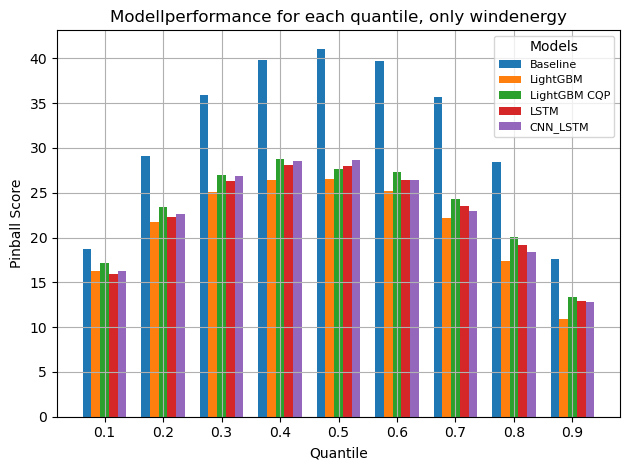

In [21]:
df_baseline_wind = pd.DataFrame(qr_model_wind.q_predictions)
df_lgbm_hp_wind = pd.DataFrame(lgbm_model_wind_hyperparameter.q_predictions)
df_lgbm_cqp_wind = pd.DataFrame(conformal_quantile_prediction_wind.q_predictions)

quantiles = np.arange(0.1, 1.0, 0.1)
quantiles = np.round(quantiles, 1)

df_list = [df_baseline_wind,df_lgbm_hp_wind, df_lgbm_cqp_wind, q_prediction_lstm_wind, q_prediction_cnn__lstm_wind ]
names = ["Baseline", "LightGBM", "LightGBM CQP","LSTM", "CNN_LSTM"]

model_utils.plot_quantile_performance(df_list, names, "Modellperformance for each quantile, only windenergy", quantiles, df_list=True)

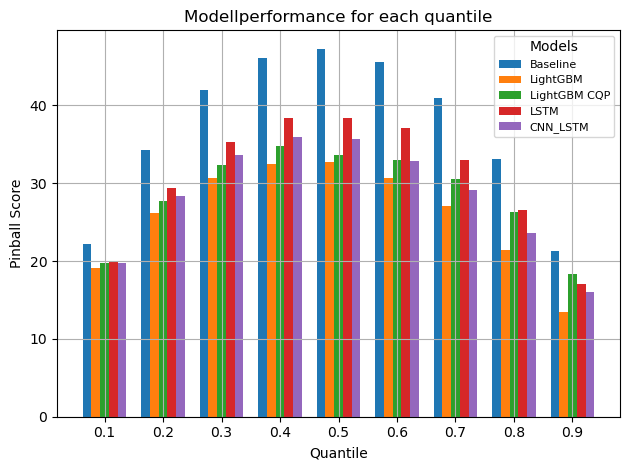

In [22]:
importlib.reload(model_utils)

df_baseline = pd.DataFrame(baseline_combined)
df_lgbm_hp = pd.DataFrame(lgbm_hp_combined)
df_lgbm_cqp = pd.DataFrame(cqp_combined)

quantiles = np.arange(0.1, 1.0, 0.1)
quantiles = np.round(quantiles, 1)

df_list = [df_baseline,df_lgbm_hp, df_lgbm_cqp, lstm_combined, cnn_lstm_combined ]
names = ["Baseline", "LightGBM", "LightGBM CQP","LSTM", "CNN_LSTM"]

model_utils.plot_quantile_performance(df_list, names, "Modellperformance for each quantile", quantiles, df_list=True)

### __Ensemble Modell__

In [26]:
from sklearn.base import BaseEstimator, RegressorMixin
import tensorflow as tf
from tensorflow.keras.saving import load_model
#wrapper to bring neural networks to sklearn format
def load_cnn(quantile, save_dir, name):
    m = tf.keras.saving.load_model(f"{save_dir}/{name}_quantile_{quantile}.h5", compile = False)

    return m
class KerasRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        # Speichert das übergebene Keras-Modell
        self.model = model

    def fit(self, X, y):
        # Hier keine Anpassung nötig, da das Modell schon trainiert wurde
        return self

    def predict(self, X):
        # Anpassung des Datenformats für Keras (falls notwendig)
        X_reshaped = X.reshape(-1, 1, X.shape[1])  # Falls das Format benötigt wird
        return self.model.predict(X_reshaped).flatten()  # flache Liste als Ausgabe

In [25]:
# from sklearn.ensemble import StackingRegressor
# from sklearn.linear_model import LinearRegression, Ridge
# from sklearn.svm import SVR

# #test stackin ensemble approach for wind energy
# q_prediction_ensemble = {}
# q_prediction_ensemble["true"] = feature_engineerer_wind.y_test.values

# for qu in quantiles:

#     # Baseline-Modelle (z.B. QR, LGBM, LSTM-CNN)
#     level0 = list()
#     # level0.append(("baseline", qr_model_wind.models[qu]))   # Annahme: Schon sklearn-kompatibel
#     level0.append(("lgbm", lgbm_model_wind_hyperparameter.models[qu]))     # Annahme: Schon sklearn-kompatibel
    
#     lstm_model = load_cnn(qu, "LSTM", "LSTM_wind")
#     lstm_wrapped = KerasRegressorWrapper(lstm_model)  # Wrap das Keras-Modell
#     level0.append(("lstm", lstm_wrapped)) 
#     # Keras-Modell mit Wrapper
#     lstm_cnn_model = load_cnn(qu, "CNN_LSTM", "CNN_LSTM_wind")
#     lstm_cnn_wrapped = KerasRegressorWrapper(lstm_cnn_model)  # Wrap das Keras-Modell
#     level0.append(("lstm_cnn", lstm_cnn_wrapped))            # Füge den Wrapper zum Stacking hinzu

#     # Meta-Modell (Final Estimator)
#     level1 = Ridge()

#     # Erstellen des Stacking Regressors
#     model = StackingRegressor(estimators=level0, final_estimator=level1)

#     # Fit mit den Validation-Daten
#     model.fit(feature_engineerer_wind.X_val, feature_engineerer_wind.y_val)

#     # Vorhersagen mit dem Stacking-Modell
#     q_prediction_ensemble[str(qu)] = model.predict(feature_engineerer_wind.X_test)

# df_ensemble = pd.DataFrame(q_prediction_ensemble)
# df_ensemble_sorted = sort_quantiles(df_ensemble, quantiles)
# df_ensemble_sorted = replace_neg_values(df_ensemble_sorted, quantiles)

# model_utils.pinball_score(df_ensemble_sorted, quantiles)